In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

In [3]:
load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\Transfer rep 5 and 6\\results\\ver1\\models\\seq_len1_b7.keras'
model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

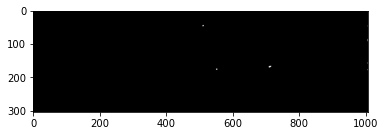

In [7]:
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\From erik\\Transfer'
col_delete_list=[0, 140, 1150, 1280]
row_delete_list=[0, 200, 350, 720, 880, 1024]
im_stack = get_image_stack(
    outputs=[0], 
    folder_path=folder_path, 
    frame_im0=, 
    im_size_width=1008, 
    im_size_height=304,
    im_resize_width=1280, 
    im_resize_height=1024,
    function_img=[RemoveRunningMean, crop_and_append_image, Normalize_image],
    row_delete_list=row_delete_list, 
    col_delete_list=col_delete_list,
    path_folder=folder_path,
    tot_no_of_frames=10, 
    im_height=1024,
    im_width=1280)

# plot_image_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,1]>0.6, cmap='gray')

In [9]:
positions = extract_positions(
    no_of_frames=100, 
    outputs=[0], 
    folder_path=folder_path, 
    frame_im0=0, 
    model=model, 
    layer=1, 
    value_threshold=0.6,
    im_size_width=1008, 
    im_size_height=304,
    im_resize_width=1280, 
    im_resize_height=1024,
    function_img=[RemoveRunningMean, crop_and_append_image, Normalize_image],
    row_delete_list=row_delete_list, 
    col_delete_list=col_delete_list,
    path_folder=folder_path,
    tot_no_of_frames=10, 
    im_height=1024,
    im_width=1280)


In [12]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=60, threshold = 5, extrapolate=True)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=1)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0, list_of_plankton=list_of_plankton)

In [ ]:
plot_and_save_track(no_of_frames=100,
                    plankton_track=plankton_track,
                    plankton_dont_track=plankton_dont_track,
                    folder_path=folder_path,
                    frame_im0=0,
                    save_images=0,
                    show_plankton_track = True,
                    show_plankton_dont_track = 0,
                    show_numbers_track = 0,
                    show_numbers_dont_track = 0,
                    show_numbers_specific_plankton = False,
                    show_specific_plankton = False,
                    specific_plankton = None,
                    color_plankton_track = 'b',
                    color_plankton_dont_track = 'r',
                    color_specific_plankton = 'w',
                    save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Alexandrium\\track',
                    frame_name = 'track',
                    file_type = '.jpg')

In [ ]:
# Make_video(frame_im0=0,
#            folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Alexandrium\\track', 
#            save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Alexandrium\\Test_video.avi', 
#            fps=7, 
#            no_of_frames=100)

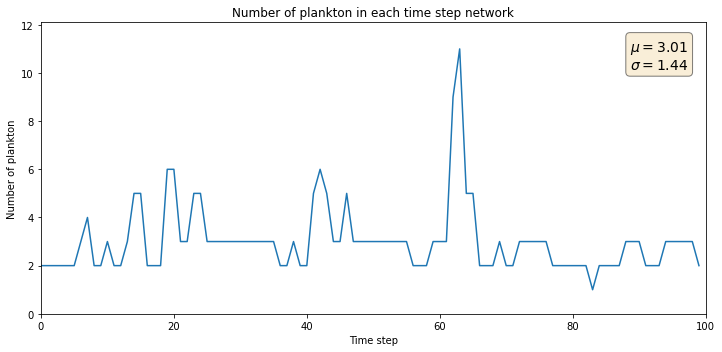

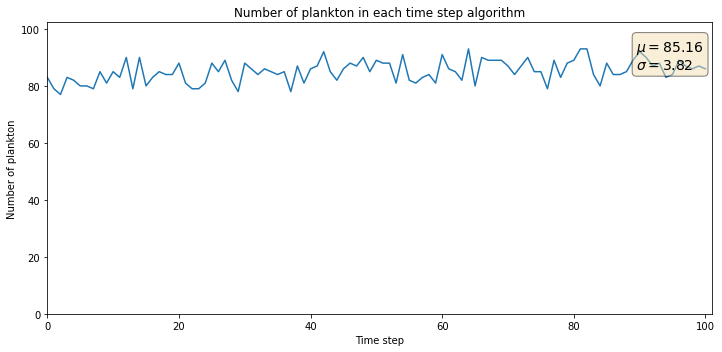

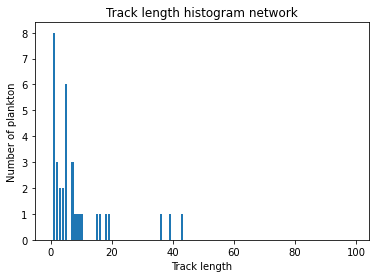

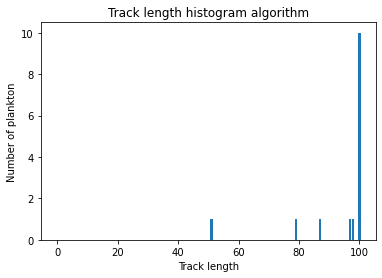

In [18]:
import xml.etree.ElementTree as ET

def plot_statistics(found_plankton_at_timestep, title):
    cropped_finds = found_plankton_at_timestep[np.nonzero(found_plankton_at_timestep)[0]]

    ax = plt.figure(figsize=(10,5))
    plt.plot(range(len(cropped_finds)), cropped_finds)
    plt.xlabel('Time step')
    plt.ylabel('Number of plankton')
    plt.title(title)
    plt.tight_layout()
    sigma = np.std(cropped_finds)
    mu = np.mean(cropped_finds)
    
    plt.axis([0, len(cropped_finds), 0, max(cropped_finds)*1.1])
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.88, 0.88, textstr, fontsize=14,
            verticalalignment='top', bbox=props)
    
def get_found_plankton_at_timestep(plankton_track):
    no_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    found_plankton_at_timestep = np.zeros(no_timesteps)

    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        for i in where_list[0]:
            found_plankton_at_timestep[i] += 1
    return found_plankton_at_timestep

def get_found_plankton_from_xml(path, no_timesteps, var_str):
    tree = ET.parse(path)
    root = tree.getroot()


    found_plankton_at_timestep = np.zeros(no_timesteps)

    for particle in root.iter():
        my_dict = particle.attrib
        if var_str in my_dict:
            found_plankton_at_timestep[int(float(my_dict[var_str]))] += 1
    return found_plankton_at_timestep


def plot_bars(track_durations, title):
    plt.figure()
    plt.bar(range(len(track_durations)), track_durations)
    
    plt.xlabel('Track length')
    plt.ylabel('Number of plankton')
    plt.title(title)



def get_track_durations(plankton_track):
    no_of_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    track_durations = np.zeros(no_of_timesteps)
    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        track_start = np.min(where_list)
        track_end = np.max(where_list)

        track_durations[track_end-track_start] += 1
    return track_durations


found_plankton_at_timestep = get_found_plankton_at_timestep(plankton_track)     
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step network')


pathbot = "E:\\Documents\\Master\\exjobb\\software\\Tracking\\Transfer_cropped_bottom_arena.xml"
pathtop = "E:\\Documents\\Master\\exjobb\\software\\Tracking\\Transfer_cropped_top_arena.xml"
no_timesteps = 101
found_plankton_at_timestep_bot = get_found_plankton_from_xml(pathbot, no_timesteps, 'POSITION_T')
found_plankton_at_timestep_top = get_found_plankton_from_xml(pathtop, no_timesteps, 'POSITION_T')
found_plankton_at_timestep = found_plankton_at_timestep_bot + found_plankton_at_timestep_top
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step algorithm')


track_durations = get_track_durations(plankton_track)
plot_bars(track_durations, 'Track length histogram network')


track_durations_top = get_found_plankton_from_xml(pathtop, no_timesteps, 'TRACK_DURATION')
track_durations_bot = get_found_plankton_from_xml(pathbot, no_timesteps, 'TRACK_DURATION')
track_durations = track_durations_top + track_durations_bot
plot_bars(track_durations, 'Track length histogram algorithm')